### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyramid.arima import auto_arima


### Dataset


In [2]:
nights = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date', parse_dates=['date'], 
                          usecols=[*range(1, 15)])
temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
gdp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])

# - IMPORTANT - Define region code here
region_code = 'PAC'

# df with data for training set
data_region = pd.concat([nights, temp, daysoff, gdp], axis=1)
data_region = data_region.dropna()
data_region = data_region[['nights_'+region_code,'avgtemp_'+region_code,'gdp_'+region_code,'daysoff']]

# df with exog data for training set; include if necessary
# exog_region = pd.concat([temp, daysoff], axis=1)
# exog_region = exog_region[['avgtemp_'+region_code,'daysoff']]

# df with nights only for testing set
nights_region = nights[['nights_'+region_code]]

### Stationarity
- *NON-STATIONARY* for all regions (need to do seasonal decompse each time)

### Seasonality
- *Multiplicative* for all regions

## Gigantic CV 'for' loop
1. Create train and test datasets (+ formatting for later)
2. Seasonal decompose
3. Predictions for: 
    - Seasonal (copypaste of last year)
    - Trend (Holt)
    - Residuals (VAR)
4. Recompose for forecast
5. Calculated error per CV step

Years of training data: ['2010', '2011']
Predicted year: 2012-01-01
VAR lag order: 3
RMSE test: 123.61220360883392
MAE test: 104.5777821421932
-------
Years of training data: ['2010', '2011', '2012']
Predicted year: 2013-01-01
VAR lag order: 3
RMSE test: 134.71467452864147
MAE test: 111.0597584312424
-------
Years of training data: ['2010', '2011', '2012', '2013']
Predicted year: 2014-01-01
VAR lag order: 3
RMSE test: 95.33940023931854
MAE test: 78.85394373119588
-------
Years of training data: ['2010', '2011', '2012', '2013', '2014']
Predicted year: 2015-01-01
VAR lag order: 3
RMSE test: 111.21860824067163
MAE test: 97.8716397433699
-------
Years of training data: ['2010', '2011', '2012', '2013', '2014', '2015']
Predicted year: 2016-01-01
VAR lag order: 3
RMSE test: 110.87313512941493
MAE test: 98.67041945482406
-------


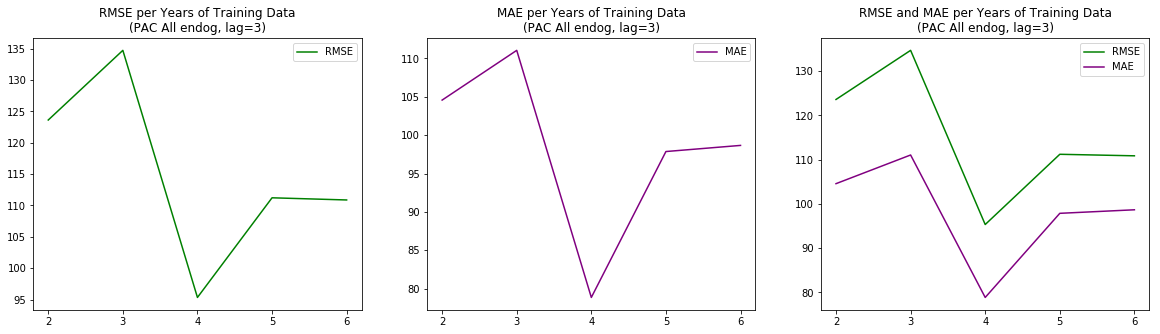

In [3]:
# - IMPORTANT - Make sure region_code is filled in properly in dataset cell above ^

input_data = data_region         # dataframe-type dataset
target = nights_region           # dataframe-type dataset
start_year = '2010-01-01'        # date as string
# exog = exog_region             # Include only if have exog data

all_mae = []
all_rmse = []
years_data = []

training_loop = range(2012, 2017)

for year in training_loop:
    end_year = str(year)+'-01-01'
    predict_year = str(year+1)+'-01-01'
    
    training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
    testing_period = (target.index>=end_year)&(target.index<predict_year)
    
    train_data = input_data[training_period]
    test_data = np.array(target[testing_period]) # Array format to calculate errors at the end
    
    # Include if have exog data
    # exog_train_data = exog[(exog.index>=start_year)&(exog.index<end_year)]
    # exog_future_data = exog[(exog.index>=end_year)&(exog.index<predict_year)]
    
    # --------Seasonal decompose----------
    
    # - IMPORTANT - Change model (multiplicative or additive) based on season type of nights
    decomposed_data = seasonal_decompose(train_data, model='multiplicative', extrapolate_trend='freq')  

    seasonal_data, trend_data, residual_data = decomposed_data.seasonal, decomposed_data.trend, decomposed_data.resid
    
    # Include if have exog data
    # exog_resid = seasonal_decompose(exog_train_data, model='additive', extrapolate_trend='freq')
    # exog_resid_data = exog_resid.resid
    
    # ---------Seasonal prediction (Same as last year of training data)---------

    # Duplicate last year's seasonal data
    seasonal_forecast = seasonal_data[(seasonal_data.index>=start_year)&(seasonal_data.index<end_year)]
    
    # Forecasted DF without datetime index and only 12 months to be able to recompose later
    # - IMPORTANT - Replace nights_PAC below with column name for your region
    seasonal_forecast_df = pd.DataFrame(seasonal_forecast.nights_PAC.values[-12:])
    
    # --------Trend prediction (Linear Holt)----------
    
    # Holt model (w/ optimized fit) on nights
    # - IMPORTANT - Replace nights_PAC below with column name for your region
    trend_model = Holt(trend_data.nights_PAC).fit(optimized=True)
    
    # Predict 12 months of trend
    trend_forecast = trend_model.predict(start=0, end=11)
    
    # Forecasted DF without datetime index to be able to recompose later
    trend_forecast_df = pd.DataFrame(trend_forecast.values) 
    
    # --------Residual prediction (VAR)----------

    # VAR model: Don't use maxlags, use specific lags in fit argument below
    # Include in VAR model function below if have exog: exog=exog_resid_data  
    resid_model = VAR(residual_data, dates=residual_data.index)    
    # - IMPORTANT - Replace lag number in fit below with desired lags
    resid_results = resid_model.fit(3)
    
    lag_order = resid_results.k_ar

    # Forecasted DF without datetime index to be able to recompose later
    # Include in VAR forecast function below if have exog: exog_future=exog_future_data
    resid_forecast_df = pd.DataFrame(resid_results.forecast(residual_data.values[-lag_order:], 12))

    # --------Recomposing results----------
    # - IMPORTANT - Addition if additive series /// Multiplication if multiplicative series
    forecast = seasonal_forecast_df[0] * trend_forecast_df[0] * resid_forecast_df[0]
    
    
    # --------Calculated error measures for each CV step----------
    rmse_test = np.sqrt(mean_squared_error(test_data, forecast))
    mae_test = mean_absolute_error(test_data, forecast)
        
    print('Years of training data:', train_data.index.strftime('%Y').unique().tolist())
    
    years_data.append(len(train_data.index.strftime('%Y').unique().tolist()))
    all_mae.append(mae_test)
    all_rmse.append(rmse_test)
    
    print('Predicted year:', end_year)
    print('VAR lag order:', lag_order)
    print('RMSE test:', rmse_test)
    print('MAE test:', mae_test)
    print('-------')

# Error measures per CrossVal loop (number of years of training data used)

x = list(range(len(years_data)))

fig, axes = plt.subplots(1,3, figsize=(20,5))
axes[0].plot(x, all_rmse, label='RMSE', color='green')
axes[0].set_xticks(x)
axes[0].set_xticklabels(years_data)
axes[0].set_title('RMSE per Years of Training Data' + '\n' + '(PAC All endog, lag=3)')
axes[0].legend()

axes[1].plot(x, all_mae, label='MAE', color='purple')
axes[1].set_xticks(x)
axes[1].set_xticklabels(years_data)
axes[1].set_title('MAE per Years of Training Data' + '\n' + '(PAC All endog, lag=3)')
axes[1].legend()

axes[2].plot(x, all_rmse, label='RMSE', color='green')
axes[2].plot(x, all_mae, label='MAE', color='purple')
axes[2].set_xticks(x)
axes[2].set_xticklabels(years_data)
axes[2].set_title('RMSE and MAE per Years of Training Data' + '\n' + '(PAC All endog, lag=3)')
axes[2].legend();